# Notebook 01: Entrenamiento y Validación del Modelo Core (GBR)
## Objetivo:

- Entrenar un modelo base (Gradient Boosting) para predecir la media de la demanda.

- Validar el rendimiento de este modelo contra los datos de 2023 y compararlo con el modelo_actual.

- Guardar el modelo entrenado y los datos de validación para los siguientes notebooks.

## 0. Configuración e Importación de Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # Para guardar el modelo

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Configuración de visualización
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 7)

## 1. Carga y Exploración de Datos (EDA)


In [2]:
# Cargar el dataset (ajusta la ruta según tu estructura)
path_datos = '../data/raw/demanding_forecast.csv'

df = pd.read_csv(path_datos)



In [3]:
# Convertir la columna 'fecha' a datetime
df['fecha'] = pd.to_datetime(df['fecha'])

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80748 entries, 0 to 80747
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   fecha            80748 non-null  datetime64[ns]
 1   prod_id          80748 non-null  int64         
 2   precio_promedio  80748 non-null  float64       
 3   ventas           80748 non-null  float64       
 4   modelo_actual    80748 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 3.1 MB
None


,fecha,prod_id,precio_promedio,ventas,modelo_actual
0,2017-01-01,0,6651.737920,1786.0,1943.551087
1,2017-02-01,0,4919.698602,2194.0,1853.111850
2,2017-03-01,0,3277.484704,1178.0,1659.733052
3,2017-04-01,0,5906.864332,1010.0,1580.492875
4,2017-05-01,0,4662.644018,1327.0,1552.062093


In [4]:
# Resumen estadístico
num_productos = df['prod_id'].nunique()
fecha_min = df['fecha'].min()
fecha_max = df['fecha'].max()

print(f"Número de productos únicos: {num_productos}")
print(f"Rango de fechas: {fecha_min.date()} a {fecha_max.date()}")

Número de productos únicos: 1000
Rango de fechas: 2012-01-01 a 2023-12-01


## Análisis de la Variable Objetivo (ventas)
Buscamos evidencia de "colas pesadas" (eventos extremos) que justifiquen nuestro modelo de riesgo (GPD).

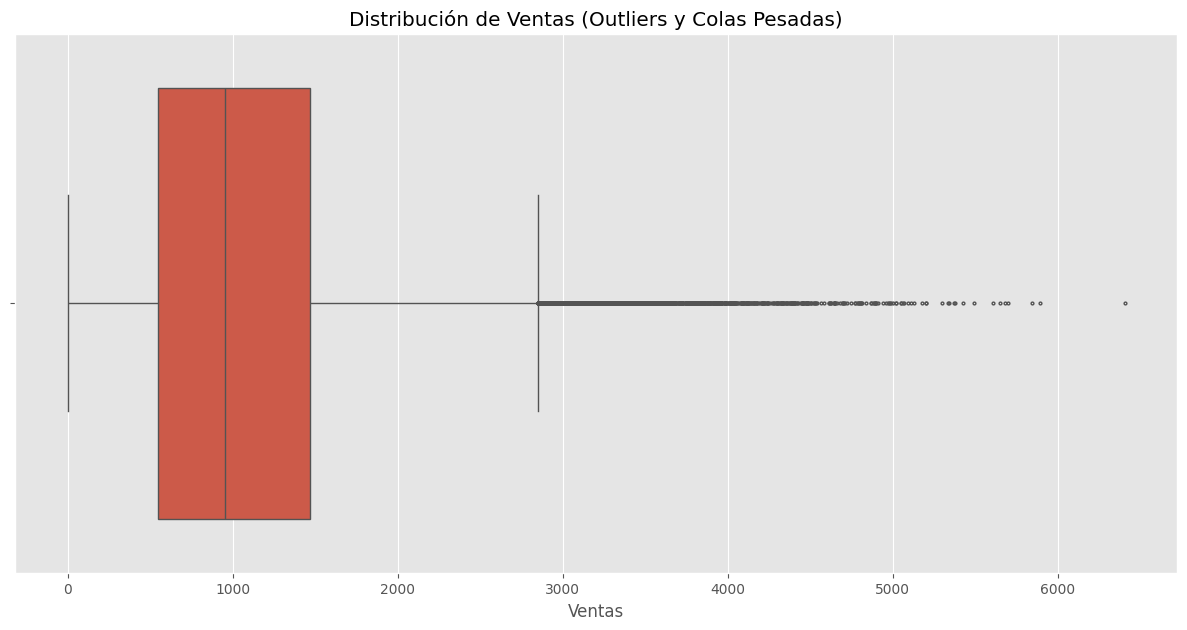

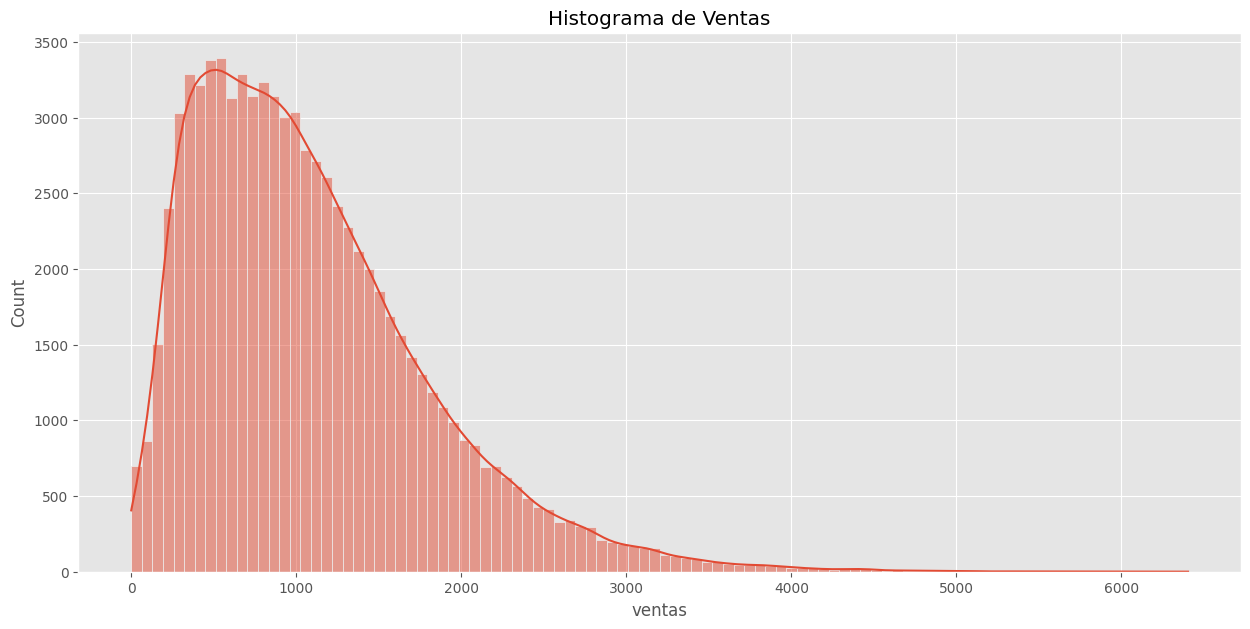

In [5]:
plt.figure(figsize=(15, 7))
sns.boxplot(x=df['ventas'], fliersize=2)
plt.title('Distribución de Ventas (Outliers y Colas Pesadas)')
plt.xlabel('Ventas')
plt.show()

plt.figure(figsize=(15, 7))
sns.histplot(df['ventas'], bins=100, kde=True)
plt.title('Histograma de Ventas')
plt.show()

Observación de EDA: El boxplot y el histograma muestran una fuerte asimetría positiva y una gran cantidad de valores atípicos (cola derecha pesada). Esto confirma que un modelo que solo predice la media (como un GBR) será insuficiente para gestionar el riesgo de picos de demanda. La idea del modelo híbrido con GPD es correcta.

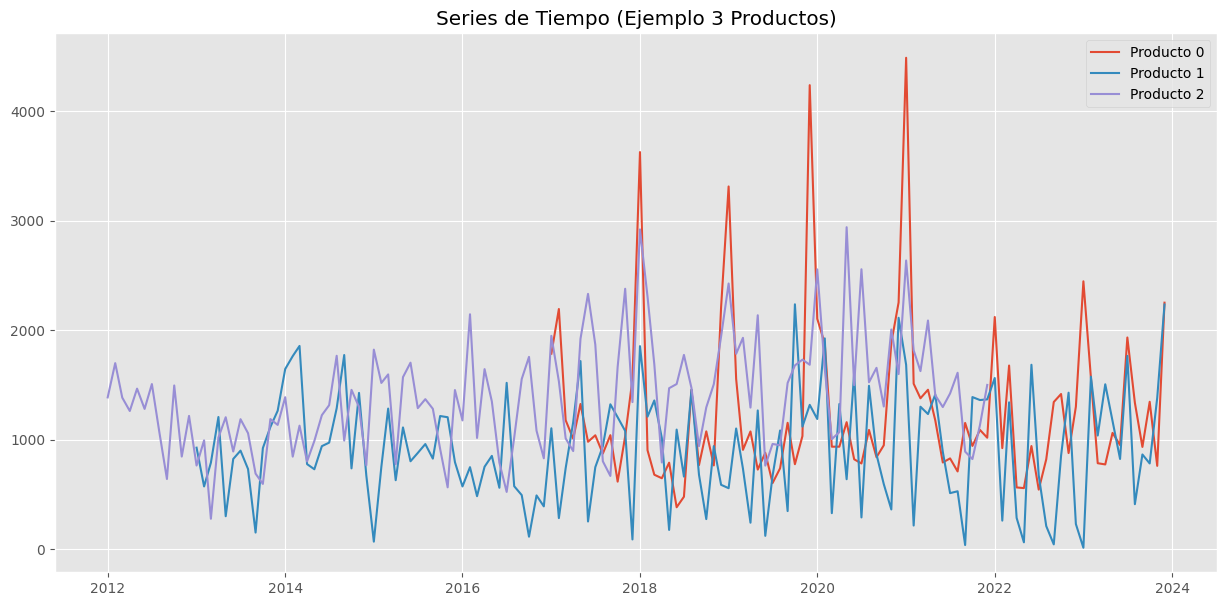

In [6]:
# Visualizar 3 series de tiempo de ejemplo
productos_ejemplo = df['prod_id'].unique()[:3]

for pid in productos_ejemplo:
    subset = df[df['prod_id'] == pid]
    plt.plot(subset['fecha'], subset['ventas'], label=f'Producto {pid}')

plt.title('Series de Tiempo (Ejemplo 3 Productos)')
plt.legend()
plt.show()

## 2. Ingeniería de Características (Feature Engineering)
Crearemos características que el modelo pueda usar. Dado que predecimos 2024 (un año completo), no podemos usar lags recientes (como lag_1 o lag_6) porque requerirían predicciones recursivas. Usaremos lags anuales, que son muy robustos para datos con estacionalidad anual.

Crearemos lags anuales (retrasos de 12 y 24 meses) para capturar la estacionalidad sin depender de predicciones recursivas.

In [7]:
def create_features(data):
    """Crea características de series de tiempo en el dataframe."""
    data = data.sort_values(['prod_id', 'fecha']).copy()
    
    # Features de Calendario
    data['year'] = data['fecha'].dt.year
    data['month'] = data['fecha'].dt.month
    
    # Lags Anuales (robustez para predicción a 12 meses)
    data['lag_12'] = data.groupby('prod_id')['ventas'].shift(12)
    data['lag_13'] = data.groupby('prod_id')['ventas'].shift(13)
    data['lag_24'] = data.groupby('prod_id')['ventas'].shift(24)
    
    # Media móvil sobre el lag para suavizar
    data['rolling_mean_3_lag12'] = data.groupby('prod_id')['lag_12'].transform(lambda x: x.rolling(3).mean())
    
    # Lag del precio (usamos el precio de hace un año como proxy)
    data['precio_lag_12'] = data.groupby('prod_id')['precio_promedio'].shift(12)
    
    return data

# Aplicar la creación de features
df_model = create_features(df)

# Eliminar filas con NaNs generados por los lags
df_model = df_model.dropna()

print("DataFrame con nuevas características:")
print(df_model.shape)
df_model.head()

DataFrame con nuevas características:
(57420, 12)


,fecha,prod_id,precio_promedio,ventas,modelo_actual,year,month,lag_12,lag_13,lag_24,rolling_mean_3_lag12,precio_lag_12
24,2019-01-01,0,3980.085684,3313.0,1930.239304,2019,1,3627.0,1553.0,1786.0,2070.666667,4475.635674
25,2019-02-01,0,6856.321659,1556.0,2144.931702,2019,2,905.0,3627.0,2194.0,2028.333333,4602.115488
26,2019-03-01,0,3854.781647,908.0,2169.396168,2019,3,681.0,905.0,1178.0,1737.666667,6828.685696
27,2019-04-01,0,3186.701689,1076.0,1618.910678,2019,4,649.0,681.0,1010.0,745.000000,5893.689061
28,2019-05-01,0,3400.851828,728.0,1053.189933,2019,5,791.0,649.0,1327.0,707.000000,5684.850661


## 3. Construcción del Modelo (Gradient Boosting)
Definimos el conjunto de entrenamiento y validación. Usaremos todos los datos hasta 2022 para entrenar, y el año 2023 completo para validar.

In [8]:
# Definir features y target
features = ['month', 'year', 'prod_id', 
            'lag_12', 'lag_13', 'lag_24', 
            'rolling_mean_3_lag12', 'precio_lag_12']
target = 'ventas'

# Dividir Train (<= 2022) y Validation (== 2023)
train = df_model[df_model['year'] < 2023]
val = df_model[df_model['year'] == 2023]

print(f"Filas de entrenamiento: {len(train)}")
print(f"Filas de validación: {len(val)}")

Filas de entrenamiento: 49800
Filas de validación: 7620


In [9]:
# Inicializar y entrenar el modelo
print("Entrenando el modelo GBR...")
gbr = GradientBoostingRegressor(
    n_estimators=500,       # Número de árboles
    learning_rate=0.05,     # Tasa de aprendizaje
    max_depth=7,            # Profundidad de los árboles
    random_state=42,
    n_iter_no_change=20,    # Parada temprana (Early Stopping)
    validation_fraction=0.1
)

gbr.fit(train[features], train[target])

print("¡Entrenamiento completado!")

Entrenando el modelo GBR...
¡Entrenamiento completado!


## 4. Guardar el Modelo Entrenado
Guardamos el objeto del modelo GBR en la carpeta models/ para usarlo en el notebook de inferencia (03-model_inference.ipynb).

In [10]:
# Guardar el modelo entrenado
path_modelo = '../models/gbr_model.joblib'
joblib.dump(gbr, path_modelo)

print(f"Modelo guardado en: {path_modelo}")

Modelo guardado en: ../models/gbr_model.joblib


## 5. Validación y Comparativa (vs. modelo_actual)
Usamos el set de validación (2023) para medir el rendimiento de nuestro modelo (WAPE y RMSE) y compararlo con el modelo_actual del cliente.

In [11]:
# 1. Predecir con nuestro nuevo modelo (GBR)
val_preds = gbr.predict(val[features])

# 2. 'val' ya tiene las 'ventas' reales Y el 'modelo_actual'.
#    Solo necesitamos añadirle nuestra nueva predicción.
val_comparativo = val.copy()
val_comparativo['pred_gbr'] = val_preds

# 3. Calcular Métricas
# 'val_comparativo' ahora tiene:
# - 'ventas' (el valor real)
# - 'modelo_actual' (la predicción original, que ya estaba en 'val')
# - 'pred_gbr' (nuestra nueva predicción)

# RMSE (Root Mean Squared Error)
rmse_gbr = np.sqrt(mean_squared_error(val_comparativo['ventas'], val_comparativo['pred_gbr']))
rmse_actual = np.sqrt(mean_squared_error(val_comparativo['ventas'], val_comparativo['modelo_actual']))

# WAPE (Weighted Absolute Percentage Error) - Métrica clave de negocio
wape_gbr = np.sum(np.abs(val_comparativo['ventas'] - val_comparativo['pred_gbr'])) / np.sum(np.abs(val_comparativo['ventas']))
wape_actual = np.sum(np.abs(val_comparativo['ventas'] - val_comparativo['modelo_actual'])) / np.sum(np.abs(val_comparativo['ventas']))

# Resultados
print("--- Comparativa de Modelos (Validación 2023) ---")
print(f"RMSE Modelo Actual: {rmse_actual:.2f}")
print(f"RMSE Nuevo Modelo (GBR): {rmse_gbr:.2f}")
print("\n")
print(f"WAPE Modelo Actual: {wape_actual:.2%}")
print(f"WAPE Nuevo Modelo (GBR): {wape_gbr:.2%}")
print("\n")
mejora_wape = (wape_actual - wape_gbr) / wape_actual
print(f"==> Mejora en WAPE (Precisión de Negocio): {mejora_wape:.2%} ==")

--- Comparativa de Modelos (Validación 2023) ---
RMSE Modelo Actual: 619.32
RMSE Nuevo Modelo (GBR): 581.06


WAPE Modelo Actual: 36.31%
WAPE Nuevo Modelo (GBR): 34.27%


==> Mejora en WAPE (Precisión de Negocio): 5.59% ==


## 6. Guardar Salida de Validación (para Notebook GPD)
Guardamos el val_comparativo (que contiene los errores/residuos) en data/interim/. Este archivo es el input para nuestro notebook 02-model_risk_gpd.ipynb.

In [12]:
# --- GUARDAR SALIDA PARA MODELO DE RIESGO ---

# El DataFrame 'val_comparativo' contiene todo lo que necesitamos:
# 'ventas' (Reales), 'pred_gbr' (Predicción Core)

# Definir la ruta de salida (siguiendo la estructura Cookiecutter)
path_salida_interim = '../data/interim/model_core_validation.csv'

# Guardar el DataFrame
val_comparativo.to_csv(path_salida_interim, index=False)

print(f"Resultados de validación (con predicciones) guardados en: {path_salida_interim}")
print(val_comparativo.head())

Resultados de validación (con predicciones) guardados en: ../data/interim/model_core_validation.csv
        fecha  prod_id  precio_promedio  ventas  modelo_actual  year  month  \
72 2023-01-01        0      5718.490738  2447.0    1662.504452  2023      1   
73 2023-02-01        0      6718.343539  1565.0    1692.611786  2023      2   
74 2023-03-01        0      5742.707352   786.0    1545.866974  2023      3   
75 2023-04-01        0      5267.384648   775.0    1340.509092  2023      4   
76 2023-05-01        0      4020.565431  1063.0    1138.194231  2023      5   

    lag_12  lag_13  lag_24  rolling_mean_3_lag12  precio_lag_12     pred_gbr  
72  2121.0  1019.0  4488.0           1410.000000    4085.525083  2111.058526  
73   924.0  2121.0  1512.0           1354.666667    6603.793792  1230.176206  
74  1678.0   924.0  1379.0           1574.333333    3723.599803  1247.068278  
75   565.0  1678.0  1457.0           1055.666667    6393.080571  1090.714359  
76   559.0   565.0  1178.0    